# To run this, you need to run (or have run) the following in docker:
```
pip install textblob
pip install nltk
pip install twitterscraper
```

In [30]:
from twitterscraper import query_tweets
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import seaborn as sns
import hypertools as hyp
import numpy as np
from textblob import TextBlob as tb
import nltk
import datetime as dt
nltk.download('brown')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Exploring twitter data

Scrape twitter for a keyword, fit topic models, do sentiment analyses on the tweets, and make a plot

In [31]:
#scrape twitter for most recent tweets on the election...this will take a while
n_tweets = 500
tweets = []
for tweet in query_tweets("election", n_tweets)[:n_tweets]:
    tweets.append(tweet)

In [32]:
tweets[0].timestamp

datetime.datetime(2017, 10, 12, 22, 29, 26)

In [33]:
#get the tweet text
tweet_text = list(map(lambda x: x.text, tweets))

In [34]:
#convert the data to a useable format
n_features = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tf = tf_vectorizer.fit_transform(tweet_text)
tf_feature_names = tf_vectorizer.get_feature_names()

In [35]:
#fit a topic model to the tweets
n_topics = 10
lda = LDA(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0).fit(tf)
tweet_topics = lda.fit(tf)

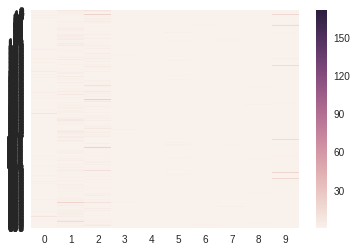

In [36]:
#topic vectors for each tweet
sns.heatmap(tweet_topics.components_.T)

In [37]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic ' + str(topic_idx) + ': ', end='')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [38]:
display_topics(lda, tf_feature_names, 10)

Topic 0: election liberia weah com http george twitter presidential news pic
Topic 1: election http com trump www won vote https news just
Topic 2: election com twitter https russia status pic pokemon used cnn
Topic 3: executive editor nytpolitics http trump election nyti like cover reporters
Topic 4: election twitter com think really won elections https status football
Topic 5: happened started election en élection les ben performing drag retire
Topic 6: wants crash burn election american yqyrq_czyum try youtube sway youtu
Topic 7: la unesco les élection en du que et israel plus
Topic 8: election way 3rd japan happening world soon october real time
Topic 9: facebook election sandberg http meddling russia 2016 sheryl america says


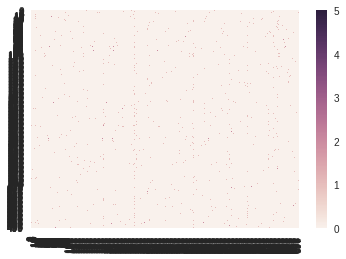

In [39]:
sns.heatmap(tf.todense())

In [40]:
blob = tb(tweet_text[0])

In [41]:
print(tweet_text[0])

Imagine all that tainted political donation $$$ from Hollywood that will have to be refused by Democrats during the next election.


In [42]:
def tweet_sentiment(tweet):
    b = tb(tweet)
    return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))

In [43]:
sentiments = list(map(tweet_sentiment, tweet_text))

In [44]:
#happiest tweet
tweet_text[np.where(sentiments == np.max(sentiments))[0][0]]

'Yes.  Yes.  Yes. And love election night videos.  “Brace for impact.”  Lol.'

In [45]:
#saddest tweet
tweet_text[np.where(sentiments == np.min(sentiments))[0][0]]

"I'm disgusted every election year by the vandalism that PETA does to all those RE-ELECT Mayor McCheese election signs."

In [46]:
print(tweet_topics.components_.T)

[[ 0.49377615  6.19928547  9.32053214 ...,  0.38934287  0.50221058
   0.3962199 ]
 [ 0.39031046  2.38092916  1.83300828 ...,  0.3831004   0.36098529
   0.39465173]
 [ 0.43919849  1.74024355  3.62235037 ...,  0.44356089  0.44634201
   0.37711106]
 ..., 
 [ 0.43465144  0.42364688  0.62765172 ...,  0.40086022  0.37386797
   0.36617939]
 [ 0.40843414  1.02451011  0.34758814 ...,  0.39515419  0.36172462
   1.09219229]
 [ 0.3848038   0.54435886  0.41860297 ...,  2.50366979  0.3691239
   0.3873185 ]]


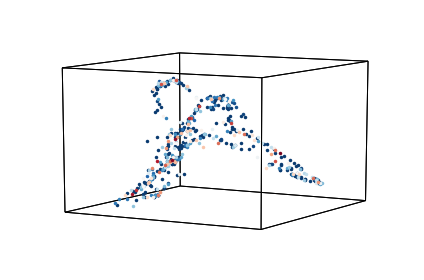

In [47]:
#make a hypertools plot of the tweets, colored by sentiment
hyp.plot(tweet_topics.components_.T, '.', group=sentiments, palette='RdBu_r', model='SpectralEmbedding');

# Defining some useful Twitter-related functions

In [48]:
# function for scraping twitter for one or more keywords and returning a dictionary with:
# - tweets: the tweet text (list of length n_tweets)
# - topicvecs: the tweet topic vectors (numpy array with n_tweets rows and n_topics columns)
# - topwords: the top n words from each topic (list of length n_topics, where each element is a list of n_words)
# - sentiments: the sentiment valence of each tweet (numpy array of length n_tweets)

def twitter_magic(keywords, n_tweets=500, n_topics=10, n_words=5, model=None):
    #if keywords is a list, combine all keywords into a single string, where each word is separated by " OR "
    if type(keywords) == list:
        keywords = ' OR '.join(keywords)
    
    #get the tweets
    tweets = []
    for tweet in query_tweets(keywords, n_tweets)[:n_tweets]:
        tweets.append(tweet)
    
    #get the tweet text
    tweet_text = list(map(lambda x: x.text, tweets))
    
    #fit a topic model to the tweet text    
    n_features = 1000
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(tweet_text)    
    vocab = tf_vectorizer.get_feature_names()
    
    if model == None:
        lda = LDA(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0).fit(tf)
    else:
        lda = model            
    tweet_topics = lda.fit(tf)
    
    def get_top_words(model, vocab, n_words):
        top_words = []
        for topic_idx, topic in enumerate(model.components_):       
            next = topic.argsort()[:-n_words - 1:-1]
            top_words.append(list(map(lambda x: vocab[x], next)))
        return top_words
    
    def tweet_sentiment(tweet):
        b = tb(tweet)
        return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))
    
    return{'tweets': tweet_text,
           'topicvecs': lda.components_.T,
           'topwords': get_top_words(lda, vocab, n_words),
           'sentiments': np.array(list(map(tweet_sentiment, tweet_text))),
           'model': lda}

In [49]:
n = 100 #number of tweets to download for each candidate

trump = twitter_magic(['election AND trump'], n_tweets=n)

#now fit clinton tweets using the topic model from trump_election_tweets (otherwise the topic vectors will be different)
clinton = twitter_magic(['election AND clinton', 'election AND hillary'], n_tweets=n, model=trump['model'])

#now fit sanders tweets (using the same topic model)
sanders = twitter_magic(['election AND sanders', 'election AND bernie'], n_tweets=n, model=trump['model'])

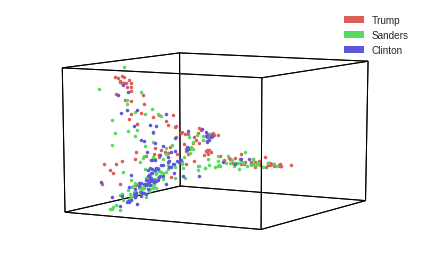

In [50]:
#plot the trump and clinton tweets
hyp.plot([trump['topicvecs'], sanders['topicvecs'], clinton['topicvecs']],
         '.', model='SpectralEmbedding', legend=['Trump', 'Sanders', 'Clinton']);

In [51]:
#get the happiest and saddest tweets from each candidate
def get_happiest_tweets(results):
    return results['tweets'][np.where(results['sentiments'] == np.max(results['sentiments']))[0][0]]

def get_saddest_tweets(results):
    return results['tweets'][np.where(results['sentiments'] == np.min(results['sentiments']))[0][0]]

candidates = ['trump', 'sanders', 'clinton']

print('HAPPIEST TWEETS:')
for c in candidates:
    print(c.upper() + '-CONTAINING: ' + get_happiest_tweets(eval(c)) + '\n')
    
print('\n\nSADDEST TWEETS:')
for c in candidates:
    print(c.upper() + '-CONTAINING: ' + get_saddest_tweets(eval(c)) + '\n')

HAPPIEST TWEETS:
TRUMP-CONTAINING: 100%.  You can count on that. Need to talk to more people who didn't vote last election. In my opinion they are our best bet.

SANDERS-CONTAINING: Did you get a refund on your bernie donations! Match me! Lol. Good luck on next election. You are REALLY gonna need it.

CLINTON-CONTAINING: True. The last election covered all this. Hillary was most qualified, Bernie may have been more exciting to dems. Vote split and Trump wins



SADDEST TWEETS:
TRUMP-CONTAINING: Our election was hacked by Russia and Russia paid big companies like Google, Facebook and twitter for ads. Voting is worthless.

SANDERS-CONTAINING: And good luck without the base in any Bernie election. See how that works? Do you even know who the base is? Women and POC.

CLINTON-CONTAINING: Faux News and the Republican Party need to get over Hillary. The p***y grabber won the election and you are still afraid of her. Sad!

